# Landcover Classificaiton

## Authored by: Blake Marshall, Sean Farmer, Jacob Sellers, & Isauro Ramos

The Landcover Classification project aims to... <CONTINUE DESCRIPTION>

#Setup

##Installs

In [161]:
%pip install rasterio
%pip install raster2xyz
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install gdal


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 

##Imports

In [162]:
import rasterio
from rasterio.plot import show
from raster2xyz.raster2xyz import Raster2xyz
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join

### File Paths

In [4]:
# I (Sam) downloaded the sample data to my own drive to access it. It will probably be a good idea to make it downloadable
path_samples = 'Data/Images/'
file_name = '1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'
path_test_tiff = path_samples + file_name


###Rasterio into Dataset?


In [5]:
dataset_1 = rasterio.open(path_test_tiff)

In [6]:
# Number of Bands
print(dataset_1.count)
# Image Resolution
print(dataset_1.height, dataset_1.width)
# CRS (Coordinate Reference System)
print(dataset_1.crs)

373
10 10
EPSG:32734


#### To Pandas DataFrame

In [7]:
# Open the GeoTIFF file
with rasterio.open(path_test_tiff) as src:
    # Read the data as a numpy array
    data = src.read(1) # Read the first band

    # Create a DataFrame with the pixel values
    df = pd.DataFrame(data)

In [8]:
# this is the first band of the tiff in relationship to the pixels. 10x10 size
df

,0,1,2,3,4,5,6,7,8,9
0,0.018910,0.013469,0.013482,0.013058,0.015231,0.013326,0.015143,0.018346,0.022535,0.019068
1,0.013689,0.014432,0.014096,0.013058,0.013822,0.015052,0.014725,0.023012,0.022535,0.015054
2,0.012368,0.014432,0.016143,0.016701,0.014553,0.017837,0.021606,0.017602,0.017759,0.020268
3,0.013629,0.013617,0.016681,0.016701,0.017036,0.017837,0.017212,0.022978,0.022861,0.018854
4,0.014638,0.014786,0.016681,0.019394,0.015752,0.016709,0.023693,0.022978,0.019632,0.018854
5,0.014638,0.018674,0.013624,0.011782,0.019361,0.023159,0.019277,0.022608,0.021807,0.024037
6,0.018140,0.012845,0.013624,0.019173,0.019361,0.017687,0.021183,0.021318,0.020814,0.024037
7,0.011680,0.012845,0.019950,0.013809,0.019371,0.020572,0.021183,0.021843,0.018080,0.020904
8,0.019009,0.016030,0.013110,0.018085,0.018236,0.021152,0.019195,0.018520,0.033191,0.032778
9,0.015614,0.016030,0.019066,0.018085,0.019728,0.021151,0.017616,0.034693,0.033191,0.011126


In [9]:
data[0,1]

np.float32(0.013469184)

#### To Numpy Array

(373, 10, 10)


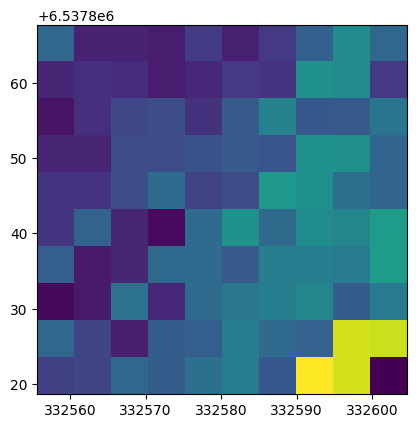

In [10]:
# Open the GeoTIFF file
with rasterio.open(path_test_tiff) as dataset:
    # Read the data as a numpy array
    data_3D = dataset.read()

    # Print the data
    print(data_3D.shape)

    # Visualize the data
    show(dataset)

###Functions using rasterio to make 1D arrays of the bands corrisponding to their pixel.

In [11]:
def tiff_to_arr(filepath):
  '''
  Description:
    This function takes a filepath to a .tiff file, opens it, and reads it as a
    numpy arr. Then returns said array.
  Input:
    filepath  : The file path to the .tiff file, starting from /content/...
  Output:
    data_3D   : A 3 dimensional array of frequency bands for the pixels of an
                image.
  '''
  with rasterio.open(filepath) as dataset:
      # Read the data as a numpy array
      data_3D = dataset.read()
  return data_3D

In [12]:
def convert_3D_to_1D(data_3D):
  '''
  Description:
    This function takes a 3 dimensional array of frequence bands when each
    individual frequence reading is a NxN 2D array. So this 3D array is BxNxN
    where B is the number of frequence bands. This function will return a N*NxB
    array. Where every individual frequence corresponding to a pixel is in the
    returned 1D array for each of the N*N pixels.
  Input:
    data_3D         : Numpy Array with 3 dimensions of shape (num_band, num_row, num_col)
  Output:
    bands_per_pixel : Numpy Array of shape (num_row * numcol, num_band)
  '''
  temp_list_1D_arr = []

  # Access the depth (third dimension) and create 1D arrays
  for i in range(data_3D.shape[1]):                 # 10 for both data_3D.shape[1] & data_3D.shape[2] to make the 10x10
    for j in range(data_3D.shape[2]):
      data_1D = data_3D[:, i, j].flatten()          # EX. this will take the [0,0] for every bands then flatten that into a 1D array. For all the bands corresponding to pixel [0,0]
      temp_list_1D_arr.append(data_1D)              # append to the temp list
  bands_per_pixel = np.array(temp_list_1D_arr)      # convert the list to a numpy array... because I want to.
  return bands_per_pixel

In [13]:
def get_filenames(directory_path):
    '''
     * Description:
     *   gets the name of both files and directories at path_samples
     *   sorted by the first numeric prefix in the filename
     * Input(s):
     *   directory_path: the path to the directory containing sample files
     * Output(s):
     *   Sorted Numpy Array of Filenames, array of strings
    '''
    filenames = []
    for f in listdir(directory_path):
        # Ignore hidden files and directories (like .DS_Store)
        if f.startswith(".") or not isfile(join(directory_path, f)):
            continue

        try:
            # Try to parse the first part of the filename as an integer
            int(f.split("_")[0])
            filenames.append(f)  # Only add to the list if parsing succeeds
        except ValueError:
            print(f"Non-numeric prefix found in filename: {f}")  # Print any problematic filename

    # Sort the valid filenames and convert to a numpy array
    return np.array(sorted(filenames, key=lambda x: int(x.split("_")[0])))

In [14]:
def make_pandas_dataframe(dir_path, filename, col_labels):
  #ds = convert_3D_to_1D(tiff_to_arr(join(dir_path, filename)))
  ds = tiff_to_arr(join(dir_path, filename))
  df = pd.DataFrame(ds, columns=col_labels)
  df['File'] = filename
  return df

In [15]:
def get_all_data(sample_directory_path):
  #Creates the frequency labels
  columns_of_frequencies = []
  for i in range(0,373,1):
    columns_of_frequencies.append("frq" + str(i))

  # get an array of the sample file names
  filenames = get_filenames(sample_directory_path)

  ## This is where we would trim the filenames for the ones we want

  #loop through and add to pandas dataframe
  list_df = []
  for i in range(0, len(filenames)):
    list_df.append(make_pandas_dataframe(sample_directory_path, filenames[i], columns_of_frequencies))
    #print(i)

  return pd.concat(list_df)

## PCA

In [16]:
def pca_make_pandas_dataframe(dir_path, filename, col_labels):
    ds = tiff_to_arr(join(dir_path, filename))  # shape is (373, 10, 10)

    # Reshape to have each pixel position with 373 band values as a row
    reshaped_ds = ds.reshape(ds.shape[0], -1).T  # Shape becomes (100, 373) or (121, 373) depending on the data
    print(f"reshaped_ds shape: {reshaped_ds.shape}")  # Check shape of reshaped_ds

    # Create the DataFrame with band columns
    df = pd.DataFrame(reshaped_ds, columns=col_labels[:reshaped_ds.shape[1]])

    # Dynamically generate X and Y coordinates based on the number of rows in reshaped_ds
    num_rows = reshaped_ds.shape[0]
    x_vals = np.tile(np.arange(10), num_rows // 10)
    y_vals = np.repeat(np.arange(10), num_rows // 10)

    # Adjust lengths in case of rounding issues
    if len(x_vals) != num_rows:
        x_vals = np.resize(x_vals, num_rows)
    if len(y_vals) != num_rows:
        y_vals = np.resize(y_vals, num_rows)

    # Check if lengths match
    print(f"Length of X: {len(x_vals)}, Length of Y: {len(y_vals)}, Num Rows: {num_rows}")
    
    df['X'] = x_vals  # X coordinates
    df['Y'] = y_vals  # Y coordinates

    # Add filename for tracking
    df['File'] = filename

    return df

In [17]:
def pca_get_all_data(sample_directory_path):
  #Creates the frequency labels
  columns_of_frequencies = []
  for i in range(0,373,1):
    columns_of_frequencies.append("frq" + str(i))

  # get an array of the sample file names
  filenames = get_filenames(sample_directory_path)

  ## This is where we would trim the filenames for the ones we want

  #loop through and add to pandas dataframe
  list_df = []
  for i in range(0, len(filenames)):
    list_df.append(pca_make_pandas_dataframe(sample_directory_path, filenames[i], columns_of_frequencies))
    #print(i)

  return pd.concat(list_df)

In [18]:
# large then needed data so that slows this down but still needs work
df = pca_get_all_data(path_samples) #this took 31 minutes to run, needs optimization.

reshaped_ds shape: (100, 373)
Length of X: 100, Length of Y: 100, Num Rows: 100
reshaped_ds shape: (100, 373)
Length of X: 100, Length of Y: 100, Num Rows: 100
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (121, 373)
Length of X: 121, Length of Y: 121, Num Rows: 121
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (144, 373)
Length of X: 144, Length of Y: 144, Num Rows: 144
reshaped_ds shape: (132, 373)
Length of X: 132, Length of Y: 132, Num Rows: 132
reshaped_ds shape: (110, 373)
Length of X: 110, Length of Y: 110, Num Rows: 110
reshaped_ds shape: (110, 373)
Length of 

In [19]:
#count file name rows? to see what images are larger?
# filenames size is 3650
df #why is there 415959 rows? aren't the sizes supposed to be 10x10

,frq0,frq1,frq2,frq3,frq4,frq5,frq6,frq7,frq8,frq9,...,frq366,frq367,frq368,frq369,frq370,frq371,frq372,X,Y,File
0,0.018910,0.025453,0.026801,0.029931,0.025996,0.030246,0.033545,0.035334,0.039591,0.044717,...,0.154068,0.154073,0.158080,0.160214,0.164343,0.173604,0.190160,0,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
1,0.013469,0.015442,0.018657,0.021459,0.028462,0.029567,0.035124,0.038447,0.039005,0.042359,...,0.143804,0.146481,0.146843,0.155816,0.159489,0.157601,0.169750,1,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
2,0.013482,0.013153,0.018295,0.021435,0.028463,0.031020,0.033894,0.037844,0.039349,0.043371,...,0.145602,0.146007,0.148808,0.149374,0.162757,0.157468,0.167964,2,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
3,0.013058,0.024265,0.024345,0.023020,0.027349,0.033271,0.032494,0.036257,0.040206,0.042641,...,0.149051,0.150941,0.147344,0.155273,0.154464,0.140058,0.165022,3,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
4,0.015231,0.024812,0.023221,0.024547,0.028005,0.033780,0.032661,0.035639,0.040920,0.043962,...,0.158802,0.157301,0.157921,0.164166,0.162148,0.151324,0.178857,4,0,1_ang20231028t101421_014_L2A_OE_main_27577724_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.110040,0.113846,0.122912,0.129257,0.133967,0.136724,0.142878,0.143184,0.149973,0.154388,...,0.077318,0.082198,0.073062,0.078871,0.106960,0.102698,0.037319,9,9,12128_ang20231031t091505_002_L2A_OE_main_27577...
60,0.090576,0.097904,0.101751,0.106854,0.110958,0.114553,0.118870,0.120013,0.125182,0.128634,...,0.048856,0.052119,0.038128,0.048034,0.072314,0.085504,0.048451,0,0,12128_ang20231031t091505_002_L2A_OE_main_27577...
61,0.109015,0.110967,0.114204,0.122206,0.125042,0.129206,0.131949,0.135035,0.139115,0.144689,...,0.063514,0.068835,0.070935,0.068684,0.062232,0.069433,0.070832,1,0,12128_ang20231031t091505_002_L2A_OE_main_27577...
62,0.127796,0.130344,0.136902,0.146922,0.151861,0.154839,0.158604,0.158993,0.164166,0.167904,...,0.088122,0.088683,0.088928,0.091659,0.105230,0.131382,0.131696,2,0,12128_ang20231031t091505_002_L2A_OE_main_27577...


In [20]:
print(df.iloc[0])
print(df.iloc[99])

frq0                                                0.01891
frq1                                               0.025453
frq2                                               0.026801
frq3                                               0.029931
frq4                                               0.025996
                                ...                        
frq371                                             0.173604
frq372                                              0.19016
X                                                         0
Y                                                         0
File      1_ang20231028t101421_014_L2A_OE_main_27577724_...
Name: 0, Length: 376, dtype: object
frq0                                               0.011126
frq1                                               0.025005
frq2                                               0.032076
frq3                                               0.029416
frq4                                               0.034397
    

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop non-numeric columns like 'X', 'Y', and 'File'
features = df.drop(columns=['X', 'Y', 'File'])

# Standardize the data (if features have different scales)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert the NumPy array to a pandas DataFrame and preserve the original index
features_scaled_df = pd.DataFrame(features_scaled, index=df.index)

In [55]:
# Drop rows with any NaN values, while preserving the index
features_scaled_dropped = features_scaled_df.dropna()

# Ensure that there are no more NaN values
print(features_scaled_dropped.isnull().sum())

# Verify the row count of features_scaled_dropped and df
print(f"features_scaled_dropped rows: {len(features_scaled_dropped)}")
print(f"Original df rows: {len(df)}")

# Initialize PCA and reduce to 2 principal components
pca = PCA(n_components=2)  # Adjust the number of components if needed
principal_components = pca.fit_transform(features_scaled_dropped)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Check the index length after dropping NaNs
print(f"pca_df rows: {len(pca_df)}")

# Reset the index of df if it has a custom index
df_reset = df.reset_index(drop=True)

# Align the rows of df with the rows that remain in features_scaled_dropped
pca_df['X'] = df_reset.loc[features_scaled_dropped.index, 'X'].values
pca_df['Y'] = df_reset.loc[features_scaled_dropped.index, 'Y'].values
pca_df['File'] = df_reset.loc[features_scaled_dropped.index, 'File'].values

# Show the first few rows of the PCA result
print(pca_df.head())

0      0
1      0
2      0
3      0
4      0
      ..
368    0
369    0
370    0
371    0
372    0
Length: 373, dtype: int64
features_scaled_dropped rows: 395034
Original df rows: 415959
pca_df rows: 395034
        PC1       PC2  X  Y                                               File
0  4.059567 -6.072723  0  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
1  2.154698 -6.107913  1  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
2  1.647049 -6.058152  2  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
3  2.442465 -6.234372  3  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...
4  4.533383 -6.185866  4  0  1_ang20231028t101421_014_L2A_OE_main_27577724_...


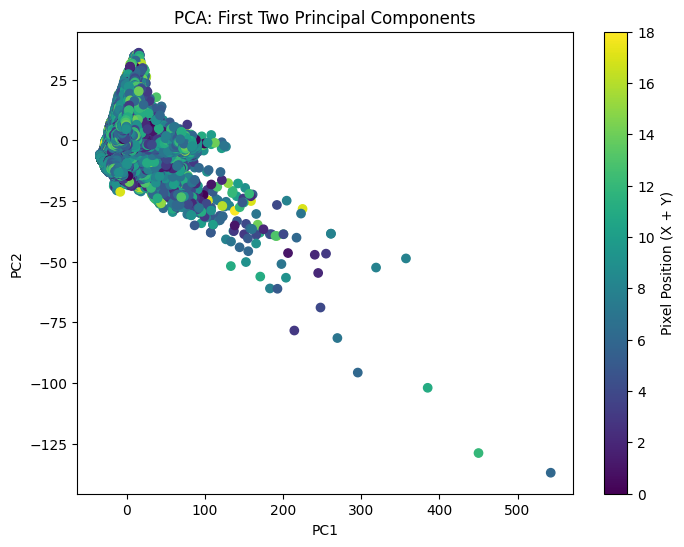

In [56]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['X'] + pca_df['Y'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Pixel Position (X + Y)')
plt.show()

In [57]:
# Explained variance ratio
print(f'Explained variance ratio for each component: {pca.explained_variance_ratio_}')

Explained variance ratio for each component: [0.751734   0.14358872]


In [152]:
# Determine the number of components to explain 90% of the variance
pca = PCA(n_components=0.90)  # Keep enough components to explain 90% variance
principal_components = pca.fit_transform(features_scaled_dropped)

print(f"Number of components to explain 90% variance: {pca.n_components_}")

Number of components to explain 90% variance: 3


In [156]:
# Access the component loadings (how much each feature contributes to each component)
component_loadings = pca.components_

# Convert it to a DataFrame for easier inspection
loadings_df = pd.DataFrame(component_loadings, columns=features.columns)

# For each component, get the top 6 features with the highest absolute loadings
top_n = pca.n_components_
top_features = {}

for i in range(loadings_df.shape[0]):  # Loop through each component
    # Sort the values by absolute magnitude and get the top 6
    sorted_loadings = loadings_df.iloc[i].abs().sort_values(ascending=False).head(top_n)
    top_features[f"Component {i+1}"] = sorted_loadings

# Convert the result to a DataFrame for better presentation
top_features_df = pd.DataFrame(top_features)

# Print the top 6 features for each component
print(top_features_df)

        Component 1  Component 2  Component 3
frq100          NaN     0.086242          NaN
frq102          NaN     0.086200          NaN
frq253     0.058133          NaN          NaN
frq254     0.058138          NaN          NaN
frq255     0.058146          NaN          NaN
frq3            NaN          NaN     0.128541
frq4            NaN          NaN     0.128608
frq5            NaN          NaN     0.128622
frq99           NaN     0.086271          NaN


In [159]:
# Create a set to store the distinct frequencies used in the top features
used_frequencies = set()

# Loop through each component and add the top N frequencies to the set
for i in range(loadings_df.shape[0]):  # Loop through each component
    # Get the top features for the component by sorting by absolute magnitude
    sorted_loadings = loadings_df.iloc[i].abs().sort_values(ascending=False).head(top_n)
    # Add the indices (frequencies) of these top features to the set
    used_frequencies.update(sorted_loadings.index)

# Count the total number of unique frequencies used
total_used_frequencies = len(used_frequencies)

# Print the total number of unique frequencies
print(f"Total number of frequencies used across all components: {total_used_frequencies}")

# Print the names of the features (frequencies) used
print("\nFrequencies used across all components:")
for feature in used_frequencies:
    print(feature)

Total number of frequencies used across all components: 9

Frequencies used across all components:
frq100
frq255
frq99
frq3
frq254
frq253
frq102
frq4
frq5


## Add Method With 5-7 Bands Here

###Convert 1D array to Panda's DataFrame

In [ ]:
columns_of_frequencies = []
for i in range(0,373,1):
  columns_of_frequencies.append("frq" + str(i))

In [ ]:
bands_to_pixels_arr = convert_3D_to_1D(tiff_to_arr(path_test_tiff))
df = pd.DataFrame(bands_to_pixels_arr, columns=columns_of_frequencies)

df['File'] = file_name
df

,frq0,frq1,frq2,frq3,frq4,frq5,frq6,frq7,frq8,frq9,...,frq364,frq365,frq366,frq367,frq368,frq369,frq370,frq371,frq372,File
0,0.018910,0.025453,0.026801,0.029931,0.025996,0.030246,0.033545,0.035334,0.039591,0.044717,...,0.160795,0.145129,0.154068,0.154073,0.158080,0.160214,0.164343,0.173604,0.190160,1_ang20231028t101421_014_L2A_OE_main_27577724_...
1,0.013469,0.015442,0.018657,0.021459,0.028462,0.029567,0.035124,0.038447,0.039005,0.042359,...,0.153601,0.140394,0.143804,0.146481,0.146843,0.155816,0.159489,0.157601,0.169750,1_ang20231028t101421_014_L2A_OE_main_27577724_...
2,0.013482,0.013153,0.018295,0.021435,0.028463,0.031020,0.033894,0.037844,0.039349,0.043371,...,0.148300,0.137497,0.145602,0.146007,0.148808,0.149374,0.162757,0.157468,0.167964,1_ang20231028t101421_014_L2A_OE_main_27577724_...
3,0.013058,0.024265,0.024345,0.023020,0.027349,0.033271,0.032494,0.036257,0.040206,0.042641,...,0.149385,0.140156,0.149051,0.150941,0.147344,0.155273,0.154464,0.140058,0.165022,1_ang20231028t101421_014_L2A_OE_main_27577724_...
4,0.015231,0.024812,0.023221,0.024547,0.028005,0.033780,0.032661,0.035639,0.040920,0.043962,...,0.160244,0.148099,0.158802,0.157301,0.157921,0.164166,0.162148,0.151324,0.178857,1_ang20231028t101421_014_L2A_OE_main_27577724_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.021151,0.024380,0.035239,0.033584,0.035645,0.041016,0.043252,0.047873,0.051074,0.052111,...,0.139757,0.133690,0.143096,0.138150,0.141279,0.152104,0.160080,0.172503,0.170343,1_ang20231028t101421_014_L2A_OE_main_27577724_...
96,0.017616,0.025192,0.034934,0.032443,0.034407,0.042204,0.044833,0.047170,0.051684,0.052533,...,0.142850,0.129573,0.137842,0.137173,0.142190,0.151477,0.156132,0.159610,0.163451,1_ang20231028t101421_014_L2A_OE_main_27577724_...
97,0.034693,0.031002,0.033019,0.039256,0.047065,0.042934,0.044410,0.048026,0.050822,0.058837,...,0.134917,0.122767,0.128189,0.131137,0.131562,0.131597,0.130821,0.129872,0.157986,1_ang20231028t101421_014_L2A_OE_main_27577724_...
98,0.033191,0.030726,0.032654,0.039991,0.045592,0.042009,0.044954,0.046063,0.050875,0.058095,...,0.126503,0.119078,0.123670,0.124726,0.126619,0.135199,0.133600,0.138676,0.151029,1_ang20231028t101421_014_L2A_OE_main_27577724_...


In [ ]:
bands_to_pixels_arr_copy = convert_3D_to_1D(tiff_to_arr(path_test_tiff))
df_copy = pd.DataFrame(bands_to_pixels_arr, columns=columns_of_frequencies)
df_copy['File'] = file_name

df = pd.concat([df,df_copy])
df

,frq0,frq1,frq2,frq3,frq4,frq5,frq6,frq7,frq8,frq9,...,frq364,frq365,frq366,frq367,frq368,frq369,frq370,frq371,frq372,File
0,0.018910,0.025453,0.026801,0.029931,0.025996,0.030246,0.033545,0.035334,0.039591,0.044717,...,0.160795,0.145129,0.154068,0.154073,0.158080,0.160214,0.164343,0.173604,0.190160,1_ang20231028t101421_014_L2A_OE_main_27577724_...
1,0.013469,0.015442,0.018657,0.021459,0.028462,0.029567,0.035124,0.038447,0.039005,0.042359,...,0.153601,0.140394,0.143804,0.146481,0.146843,0.155816,0.159489,0.157601,0.169750,1_ang20231028t101421_014_L2A_OE_main_27577724_...
2,0.013482,0.013153,0.018295,0.021435,0.028463,0.031020,0.033894,0.037844,0.039349,0.043371,...,0.148300,0.137497,0.145602,0.146007,0.148808,0.149374,0.162757,0.157468,0.167964,1_ang20231028t101421_014_L2A_OE_main_27577724_...
3,0.013058,0.024265,0.024345,0.023020,0.027349,0.033271,0.032494,0.036257,0.040206,0.042641,...,0.149385,0.140156,0.149051,0.150941,0.147344,0.155273,0.154464,0.140058,0.165022,1_ang20231028t101421_014_L2A_OE_main_27577724_...
4,0.015231,0.024812,0.023221,0.024547,0.028005,0.033780,0.032661,0.035639,0.040920,0.043962,...,0.160244,0.148099,0.158802,0.157301,0.157921,0.164166,0.162148,0.151324,0.178857,1_ang20231028t101421_014_L2A_OE_main_27577724_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.021151,0.024380,0.035239,0.033584,0.035645,0.041016,0.043252,0.047873,0.051074,0.052111,...,0.139757,0.133690,0.143096,0.138150,0.141279,0.152104,0.160080,0.172503,0.170343,1_ang20231028t101421_014_L2A_OE_main_27577724_...
96,0.017616,0.025192,0.034934,0.032443,0.034407,0.042204,0.044833,0.047170,0.051684,0.052533,...,0.142850,0.129573,0.137842,0.137173,0.142190,0.151477,0.156132,0.159610,0.163451,1_ang20231028t101421_014_L2A_OE_main_27577724_...
97,0.034693,0.031002,0.033019,0.039256,0.047065,0.042934,0.044410,0.048026,0.050822,0.058837,...,0.134917,0.122767,0.128189,0.131137,0.131562,0.131597,0.130821,0.129872,0.157986,1_ang20231028t101421_014_L2A_OE_main_27577724_...
98,0.033191,0.030726,0.032654,0.039991,0.045592,0.042009,0.044954,0.046063,0.050875,0.058095,...,0.126503,0.119078,0.123670,0.124726,0.126619,0.135199,0.133600,0.138676,0.151029,1_ang20231028t101421_014_L2A_OE_main_27577724_...


In [ ]:
x = df.iloc[0].equals(df.iloc[100])
print(x)
y = df.iloc[50].equals(df.iloc[150])
print(y)
z = df.iloc[99].equals(df.iloc[199])
print(z)

True
True
True


####Get file names

In [ ]:
# gets the name of both files and directories at path_samples
# joins the path and the file names then checks if that is a file
# if it is a file and not a directory it is added to the list filenames
# once the list of file names is created, it is then sorted by number: '#_...'
# the list is then converted to numpy array just cause.

#convert_to_numpy_array(sort(get_list_of_only_filenames, sort_by_first_number_in_name))

filenames = np.array(sorted([f for f in listdir(path_samples) if isfile(join(path_samples, f))], key=lambda x: int(x.split("_")[0])))

In [ ]:
filenames

array(['1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif',
       '2_ang20231028t100428_001_L2A_OE_main_27577724_RFL_ORT.tif',
       '2_ang20231028t095542_011_L2A_OE_main_27577724_RFL_ORT.tif', ...,
       '12128_ang20231031t091505_002_L2A_OE_main_27577724_RFL_ORT.tif',
       '12128_ang20231109t063500_001_L2A_OE_main_27577724_RFL_ORT.tif',
       '12128_ang20231031t092656_025_L2A_OE_main_27577724_RFL_ORT.tif'],
      dtype='<U61')

In [ ]:
print(filenames.size)
x = np.where(filenames == file_name)
x

3650


(array([0]),)

In [ ]:
filenames[2279]

'1_ang20231028t101421_014_L2A_OE_main_27577724_RFL_ORT.tif'

### Raster2xyz into csv => panda's dataframe

In [ ]:
input_raster = path_test_tiff
out_csv = "/content/datasets/out_tiff_1.csv"

rtxyz = Raster2xyz()
rtxyz.translate(input_raster, out_csv)

myRasterDF = pd.read_csv(out_csv)

myRasterDF

,x,y,z
0,332558.086808,6.537865e+06,0.018910
1,332562.986808,6.537865e+06,0.013469
2,332567.886808,6.537865e+06,0.013482
3,332572.786808,6.537865e+06,0.013058
4,332577.686808,6.537865e+06,0.015231
...,...,...,...
95,332582.586808,6.537821e+06,0.021151
96,332587.486808,6.537821e+06,0.017616
97,332592.386808,6.537821e+06,0.034693
98,332597.286808,6.537821e+06,0.033191


##GDAL